In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:

import zipfile
import os

Dataset_zip = '/content/drive/MyDrive/DIV2K.zip'
Dataset_extract = '/content/DIV2K/'
with zipfile.ZipFile(Dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(Dataset_extract)
print("Extracted files:", os.listdir(Dataset_extract))


Extracted files: ['DIV2K', '__MACOSX']


In [7]:
from PIL import Image
from torchvision import transforms
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import torch.nn as nn
import cv2
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchinfo import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from PIL import Image
from torchvision import transforms
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class Dataset_loading(Dataset):
    def __init__(self, HR_imgs, LR_imgs, PatchSize=128):
        """
        Initialize the dataset for image restoration.

        :param HR_imgs: Directory of High-Resolution (HR) images
        :param LR_imgs: Directory of Low-Resolution (LR) images
        :param PatchSize: Size of patches to crop (default 128) the gpu and RAM i have is compatible for patch size 128
        """
        self.HR_imgs = HR_imgs
        self.LR_imgs = LR_imgs
        self.PatchSize = PatchSize

        self.PatchSize = [f for f in os.listdir(HR_imgs) if f.endswith(('.png', '.jpg'))]

        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.resize = transforms.Resize((PatchSize, PatchSize))

    def __len__(self):
        """
        returns total number of HR Images in dataset
        """
        return len(self.PatchSize)

    def __getitem__(self, idx):
        """
        load the HR and LR image pair after random crop and resize.
        :param idx: Index of the image in the dataset
        :return: Tuple of LR and HR images
        """

        HR_img_name = self.PatchSize[idx]
        HR_img_path = os.path.join(self.HR_imgs, HR_img_name)

        LR_img_name = HR_img_name.replace('.png', 'x4.png')
        LR_img_path = os.path.join(self.LR_imgs, LR_img_name)

        if not os.path.exists(LR_img_path):
            raise FileNotFoundError(f" image not found: {LR_img_path}")
        HR_Img = Image.open(HR_img_path).convert('RGB')
        LR_Img = Image.open(LR_img_path).convert('RGB')


        # resize both images to the PatchSize
        HR_Img = self.resize(HR_Img)
        LR_Img = self.resize(LR_Img)
        HR_Img = self.transform(HR_Img)
        LR_Img = self.transform(LR_Img)

        return LR_Img, HR_Img


In [9]:
class ImageRestoration_model(nn.Module):
    def __init__(self, total_channels=64, total_blocks=16):
        super(ImageRestoration_model, self).__init__()
        self.conv_input = nn.Sequential(
            nn.Conv2d(3, total_channels, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.residual_blocks = nn.ModuleList([
            nn.Conv2d(total_channels, total_channels, kernel_size=3, padding=1) for _ in range(total_blocks)
        ])


        self.upsampling = nn.Sequential(
            nn.Conv2d(total_channels, total_channels * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(total_channels, total_channels * 4, kernel_size=3, padding=1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

        self.conv_output = nn.Conv2d(total_channels, 3, kernel_size=3, padding=1)

    def forward(self, x):
        f = self.conv_input(x)
        for block in self.residual_blocks:
            f = F.relu(block(f)) + f

        out = self.upsampling(f)
        out = self.conv_output(out)
        return torch.clamp(out, 0, 1)

In [10]:
def Estimate_PSNR(Output, HR_imgs):
    """
   Estimation of PSNR (Peak Signal to Noise Ratio) between model outputs and high-resolution ground truth image inputs.
    """
    if Output.size() != HR_imgs.size():
        Output = F.interpolate(Output, size=HR_imgs.shape[2:], mode='bilinear', align_corners=False)
    Output = Output.clamp(0, 1)
    HR_imgs = HR_imgs.clamp(0, 1)
    MSE = torch.mean((Output - HR_imgs) ** 2, dim=[1, 2, 3])
    epsilon = 1e-10
    MSE = torch.clamp(MSE, min=epsilon)
    PSNR = 10 * torch.log10(1.0 / MSE)
    return PSNR.mean().item()

In [11]:
def train_restoration_model(model, TrainLoader, Valid_Loader, device, total_epochs=100):
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    best_PSNR = 0
    for epoch in range(total_epochs):
        model.train()
        TrainLoss = 0
        V_batches = 0
        for LR_imgs, HR_imgs in tqdm(TrainLoader):
            LR_imgs, HR_imgs = LR_imgs.to(device), HR_imgs.to(device)
            optimizer.zero_grad()
            outputs = model(LR_imgs)
            output_resized = F.interpolate(outputs, size=(HR_imgs.size(2), HR_imgs.size(3)), mode='bilinear', align_corners=False)
            loss = criterion(output_resized, HR_imgs)
            loss.backward()
            optimizer.step()
            TrainLoss += loss.item()
            V_batches += 1
        TrainLoss /= V_batches

        # validation
        model.eval()
        Valid_PSNR = 0
        with torch.no_grad():
            for LR_imgs, HR_imgs in Valid_Loader:
                LR_imgs, HR_imgs = LR_imgs.to(device), HR_imgs.to(device)
                outputs = model(LR_imgs)
                Valid_PSNR += Estimate_PSNR(outputs, HR_imgs)

        Valid_PSNR /= len(Valid_Loader)
        scheduler.step(Valid_PSNR)
        print(f'Epoch [{epoch+1}/{total_epochs}], Loss: {TrainLoss:.4f}, PSNR: {Valid_PSNR:.2f}')

        if Valid_PSNR > best_PSNR:
            best_PSNR = Valid_PSNR
            torch.save(model.state_dict(), 'Final_RestorationModel.pth')


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TrainHR_imgs = '/content/DIV2K/DIV2K/DIV2K_train_HR'
TrainLR_imgs = '/content/DIV2K/DIV2K/DIV2K_train_LR_bicubic/X4'
ValidHR_imgs = '/content/DIV2K/DIV2K/DIV2K_valid_HR'
ValidLR_imgs = '/content/DIV2K/DIV2K/DIV2K_valid_LR_bicubic/X4'


TrainDataset = Dataset_loading(TrainHR_imgs, TrainLR_imgs)
ValidDataset = Dataset_loading(ValidHR_imgs, ValidLR_imgs)

TrainLoader = torch.utils.data.DataLoader(TrainDataset, batch_size=8, shuffle=True)
Valid_Loader = torch.utils.data.DataLoader(ValidDataset, batch_size=8, shuffle=False)

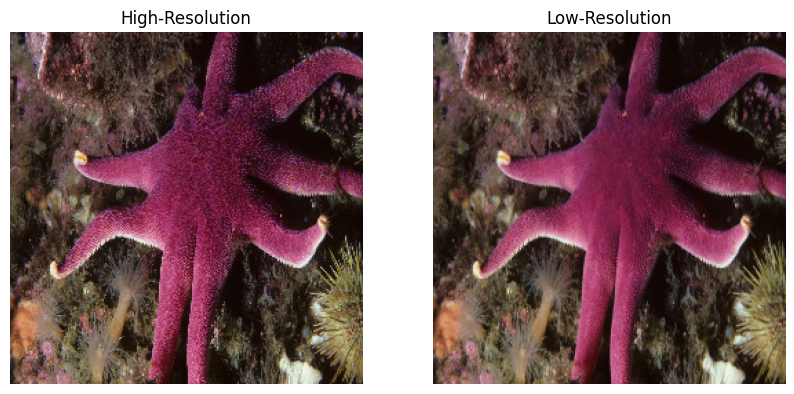

In [13]:
def Get_Images(image_dir, img_size=None):
    imgs = []
    for fn in sorted(os.listdir(image_dir)):
        if fn.endswith('.png') or fn.endswith('.jpg'):
            ImgPath = os.path.join(image_dir, fn)
            img = cv2.imread(ImgPath)
            if img_size:
                img = cv2.resize(img, img_size)
            imgs.append(img)
    return imgs
HR_img = Get_Images(TrainHR_imgs, img_size=(256, 256))
LR_img = Get_Images(TrainLR_imgs, img_size=(256, 256))
def show_images(hr, lr, idx=0):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(hr[idx], cv2.COLOR_BGR2RGB))
    plt.title("High-Resolution")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(lr[idx], cv2.COLOR_BGR2RGB))
    plt.title("Low-Resolution")
    plt.axis('off')
    plt.show()

show_images(HR_img, LR_img, idx=0)

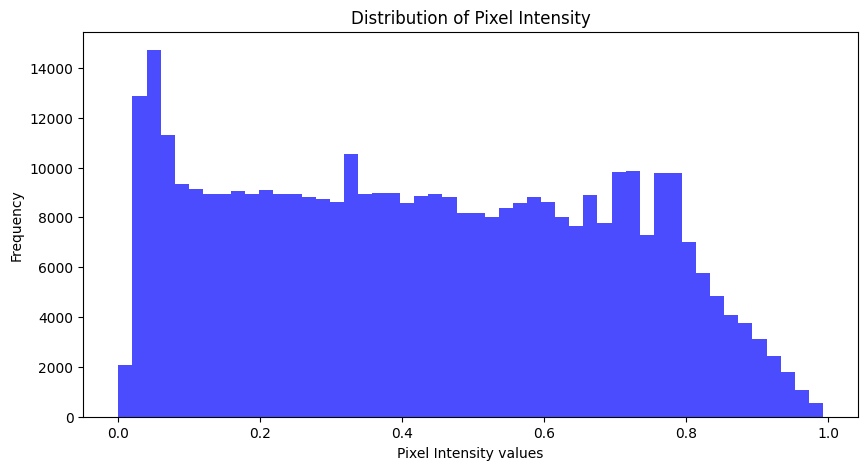

In [14]:
def Distribution_of_Pixel_Intensity(loader, num_images=10):
    pixels = []
    dt = iter(loader)
    LR_imgs, _ = next(dt)
    for i in range(min(num_images, len(LR_imgs))):
        pixels.extend(LR_imgs[i].cpu().numpy().ravel())

    plt.figure(figsize=(10, 5))
    plt.hist(pixels, bins=50, color="blue", alpha=0.7)
    plt.xlabel("Pixel Intensity values")
    plt.ylabel("Frequency")
    plt.title("Distribution of Pixel Intensity")
    plt.show()

Distribution_of_Pixel_Intensity(TrainLoader, num_images=10)


In [15]:
model = ImageRestoration_model().to(device)

In [16]:
summary(model)

Layer (type:depth-idx)                   Param #
ImageRestoration_model                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       15,616
│    └─PReLU: 2-2                        1
├─ModuleList: 1-2                        --
│    └─Conv2d: 2-3                       36,928
│    └─Conv2d: 2-4                       36,928
│    └─Conv2d: 2-5                       36,928
│    └─Conv2d: 2-6                       36,928
│    └─Conv2d: 2-7                       36,928
│    └─Conv2d: 2-8                       36,928
│    └─Conv2d: 2-9                       36,928
│    └─Conv2d: 2-10                      36,928
│    └─Conv2d: 2-11                      36,928
│    └─Conv2d: 2-12                      36,928
│    └─Conv2d: 2-13                      36,928
│    └─Conv2d: 2-14                      36,928
│    └─Conv2d: 2-15                      36,928
│    └─Conv2d: 2-16                      36,928
│    └─Conv2d: 2-17                      36,928
│    └─C

In [ ]:
model = ImageRestoration_model().to(device)
train_restoration_model(model, TrainLoader, Valid_Loader, device, total_epochs=100)


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [1/100], Loss: 0.0995, PSNR: 19.96


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [2/100], Loss: 0.0715, PSNR: 21.01


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [3/100], Loss: 0.0601, PSNR: 21.64


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [4/100], Loss: 0.0572, PSNR: 22.09


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [5/100], Loss: 0.0532, PSNR: 22.13


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [6/100], Loss: 0.0516, PSNR: 21.97


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [7/100], Loss: 0.0480, PSNR: 22.72


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [8/100], Loss: 0.0470, PSNR: 22.90


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [9/100], Loss: 0.0417, PSNR: 27.89


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [10/100], Loss: 0.0279, PSNR: 28.40


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [11/100], Loss: 0.0245, PSNR: 28.01


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [12/100], Loss: 0.0291, PSNR: 29.31


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [13/100], Loss: 0.0242, PSNR: 29.48


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [14/100], Loss: 0.0247, PSNR: 29.64


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [15/100], Loss: 0.0220, PSNR: 30.05


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [16/100], Loss: 0.0235, PSNR: 30.16


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [17/100], Loss: 0.0212, PSNR: 27.75


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [18/100], Loss: 0.0229, PSNR: 30.75


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [19/100], Loss: 0.0215, PSNR: 30.37


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [20/100], Loss: 0.0202, PSNR: 30.89


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [21/100], Loss: 0.0195, PSNR: 30.89


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [22/100], Loss: 0.0226, PSNR: 30.58


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [23/100], Loss: 0.0210, PSNR: 30.24


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [24/100], Loss: 0.0194, PSNR: 30.87


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [25/100], Loss: 0.0196, PSNR: 30.96


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [26/100], Loss: 0.0200, PSNR: 31.46


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [27/100], Loss: 0.0183, PSNR: 31.64


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [28/100], Loss: 0.0181, PSNR: 31.66


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [29/100], Loss: 0.0188, PSNR: 31.90


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [30/100], Loss: 0.0193, PSNR: 30.99


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [31/100], Loss: 0.0190, PSNR: 30.53


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [32/100], Loss: 0.0188, PSNR: 31.61


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [33/100], Loss: 0.0178, PSNR: 30.46


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [34/100], Loss: 0.0181, PSNR: 32.11


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [35/100], Loss: 0.0194, PSNR: 32.07


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [36/100], Loss: 0.0180, PSNR: 30.79


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [37/100], Loss: 0.0188, PSNR: 31.46


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [38/100], Loss: 0.0181, PSNR: 31.49


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [39/100], Loss: 0.0177, PSNR: 31.73


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [40/100], Loss: 0.0168, PSNR: 31.68


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [41/100], Loss: 0.0152, PSNR: 32.62


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [42/100], Loss: 0.0145, PSNR: 32.71


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [43/100], Loss: 0.0148, PSNR: 32.62


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [44/100], Loss: 0.0143, PSNR: 32.77


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [45/100], Loss: 0.0155, PSNR: 32.77


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [46/100], Loss: 0.0146, PSNR: 32.86


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [47/100], Loss: 0.0145, PSNR: 32.64


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [48/100], Loss: 0.0148, PSNR: 32.94


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [49/100], Loss: 0.0141, PSNR: 32.87


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [50/100], Loss: 0.0149, PSNR: 32.92


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [51/100], Loss: 0.0146, PSNR: 33.03


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [52/100], Loss: 0.0145, PSNR: 32.62


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [53/100], Loss: 0.0141, PSNR: 33.15


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [54/100], Loss: 0.0145, PSNR: 33.18


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [55/100], Loss: 0.0143, PSNR: 32.92


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [56/100], Loss: 0.0143, PSNR: 33.05


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [57/100], Loss: 0.0145, PSNR: 32.12


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [58/100], Loss: 0.0148, PSNR: 33.09


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [59/100], Loss: 0.0138, PSNR: 33.13


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [60/100], Loss: 0.0147, PSNR: 32.45


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [61/100], Loss: 0.0132, PSNR: 33.50


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [62/100], Loss: 0.0127, PSNR: 33.53


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [63/100], Loss: 0.0127, PSNR: 33.56


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [64/100], Loss: 0.0126, PSNR: 33.59


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [65/100], Loss: 0.0128, PSNR: 33.58


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [66/100], Loss: 0.0127, PSNR: 33.57


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [67/100], Loss: 0.0126, PSNR: 33.67


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [68/100], Loss: 0.0128, PSNR: 33.66


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [69/100], Loss: 0.0127, PSNR: 33.70


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [70/100], Loss: 0.0125, PSNR: 33.64


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [71/100], Loss: 0.0126, PSNR: 33.70


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [72/100], Loss: 0.0127, PSNR: 33.78


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [73/100], Loss: 0.0128, PSNR: 33.27


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [74/100], Loss: 0.0127, PSNR: 33.67


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [75/100], Loss: 0.0124, PSNR: 33.80


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [76/100], Loss: 0.0128, PSNR: 33.56


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [77/100], Loss: 0.0125, PSNR: 33.66


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [78/100], Loss: 0.0125, PSNR: 33.73


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Epoch [79/100], Loss: 0.0124, PSNR: 33.53


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [80/100], Loss: 0.0127, PSNR: 33.78


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [81/100], Loss: 0.0124, PSNR: 33.86


100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


Epoch [82/100], Loss: 0.0126, PSNR: 33.95


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Epoch [83/100], Loss: 0.0122, PSNR: 33.94


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


Epoch [84/100], Loss: 0.0121, PSNR: 33.60


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [85/100], Loss: 0.0127, PSNR: 33.97


100%|██████████| 100/100 [01:59<00:00,  1.19s/it]


Epoch [86/100], Loss: 0.0121, PSNR: 33.81


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [87/100], Loss: 0.0120, PSNR: 33.84


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [88/100], Loss: 0.0120, PSNR: 33.60


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [89/100], Loss: 0.0123, PSNR: 33.95


100%|██████████| 100/100 [02:02<00:00,  1.22s/it]


Epoch [90/100], Loss: 0.0124, PSNR: 33.98


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [91/100], Loss: 0.0122, PSNR: 34.02


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [92/100], Loss: 0.0119, PSNR: 34.02


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [93/100], Loss: 0.0120, PSNR: 33.70


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [94/100], Loss: 0.0123, PSNR: 34.01


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Epoch [95/100], Loss: 0.0120, PSNR: 34.05


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [96/100], Loss: 0.0121, PSNR: 34.15


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [97/100], Loss: 0.0118, PSNR: 33.93


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


Epoch [98/100], Loss: 0.0119, PSNR: 34.14


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


Epoch [99/100], Loss: 0.0123, PSNR: 34.02


100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


Epoch [100/100], Loss: 0.0119, PSNR: 34.16


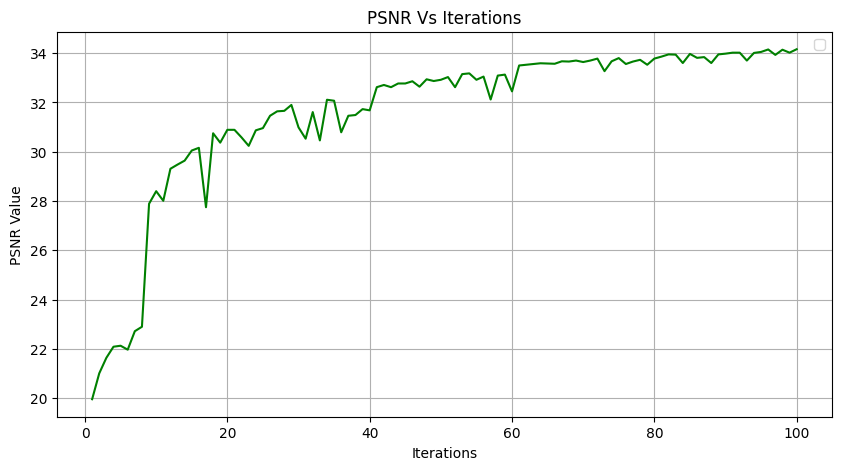

In [22]:
#below are the PSNR and Loss values of above result (model takes lots of time to run so just listed down)
PSNR = [19.96, 21.01, 21.64, 22.09, 22.13, 21.97, 22.72, 22.9, 27.89, 28.4, 28.01, 29.31, 29.48, 29.64, 30.05, 30.16, 27.75, 30.75, 30.37, 30.89, 30.89, 30.58, 30.24, 30.87, 30.96, 31.46, 31.64, 31.66, 31.9, 30.99, 30.53, 31.61, 30.46, 32.11, 32.07, 30.79, 31.46, 31.49, 31.73, 31.68, 32.62, 32.71, 32.62, 32.77, 32.77, 32.86, 32.64, 32.94, 32.87, 32.92, 33.03, 32.62, 33.15, 33.18, 32.92, 33.05, 32.12, 33.09, 33.13, 32.45, 33.5, 33.53, 33.56, 33.59, 33.58, 33.57, 33.67, 33.66, 33.7, 33.64, 33.7, 33.78, 33.27, 33.67, 33.8, 33.56, 33.66, 33.73, 33.53, 33.78, 33.86, 33.95, 33.94, 33.6, 33.97, 33.81, 33.84, 33.6, 33.95, 33.98, 34.02, 34.02, 33.7, 34.01, 34.05, 34.15, 33.93, 34.14, 34.02, 34.16]
LOSS = [0.0995, 0.0715, 0.0601, 0.0572, 0.0532, 0.0516, 0.048, 0.047, 0.0417, 0.0279, 0.0245, 0.0291, 0.0242, 0.0247, 0.022, 0.0235, 0.0212, 0.0229, 0.0215, 0.0202, 0.0195, 0.0226, 0.021, 0.0194, 0.0196, 0.02, 0.0183, 0.0181, 0.0188, 0.0193, 0.019, 0.0188, 0.0178, 0.0181, 0.0194, 0.018, 0.0188, 0.0181, 0.0177, 0.0168, 0.0152, 0.0145, 0.0148, 0.0143, 0.0155, 0.0146, 0.0145, 0.0148, 0.0141, 0.0149, 0.0146, 0.0145, 0.0141, 0.0145, 0.0143, 0.0143, 0.0145, 0.0148, 0.0138, 0.0147, 0.0132, 0.0127, 0.0127, 0.0126, 0.0128, 0.0127, 0.0126, 0.0128, 0.0127, 0.0125, 0.0126, 0.0127, 0.0128, 0.0127, 0.0124, 0.0128, 0.0125, 0.0125, 0.0124, 0.0127, 0.0124, 0.0126, 0.0122, 0.0121, 0.0127, 0.0121, 0.012, 0.012, 0.0123, 0.0124, 0.0122, 0.0119, 0.012, 0.0123, 0.012, 0.0121, 0.0118, 0.0119, 0.0123, 0.0119]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(PSNR) + 1), PSNR,color="green")
plt.xlabel("Iterations")
plt.ylabel("PSNR Value")
plt.title("PSNR Vs Iterations")
plt.grid(True)
plt.legend()
plt.show()

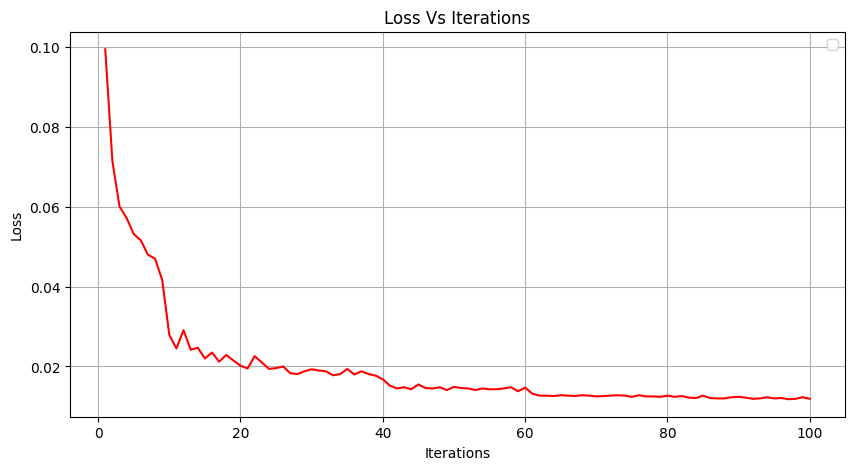

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(LOSS) + 1), LOSS, color="red")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Vs Iterations")
plt.grid(True)
plt.legend()
plt.show()